# Model training and prediction

## Run a prediction on a set of images
### Preparation
Set the class, model name and model epoch number
Run the Write Annot cell
Run the Prediction Config cell
Verify the folder for the images to be predicted as well as output


In [ ]:
#Set up the directory
new_dir = "/home/student/data_5000_project/programs/R-CNN/"
%cd $new_dir
!pwd

In [ ]:
!python -V

Run
!sudo git clone https://github.com/matterport/Mask_RCNN.git

Data is in 
/home/student/data_5000_project/data/images/construction_types/processed/opus_incertum

In [ ]:
!pwd


In [ ]:
#if not /home/student/data_5000_project/programs/R-CNN/Mask_RCNN
%cd Mask_RCNN

In [ ]:
!python setup.py install

In [ ]:
!pip install scikit-image

In [ ]:
!pip show mask-rcnn
!pwd

In [1]:
# split into train and test set
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
construction_type = "charcoal_hearth_hill"

class ObjectDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, construction_type)
        # define data locations
        images_dir = dataset_dir + '/images_training/'
        #basic training
        annotations_dir = dataset_dir + '/annots/'
        #training on annotations made after a model did predictions
        #annotations_dir = '/storage/images/charcoal_hearth_hill/predictions/cfg20200624T1134/unknown/edited/fixed/'
        # find all images
        file_cn=0
        for filename in listdir(images_dir):
            file_cn=file_cn+1
            # extract image id
            image_id = filename[:-4]
            # We need 20% of cases to test. 
            # Files are numbered. 
            # If a file ends in 4 or 9, it's for testing. 

            if(file_cn%10==4 or file_cn%10==9):
                if(is_train):
                    continue
            else:
                if not (is_train):
                    continue
            
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
            # print(file_cn, image_id, img_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # count bounding boxes from an annotation file
    def count_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        box_count=0
        for box in root.findall('.//bndbox'):
            box_count=box_count+1
        return box_count

    
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(construction_type))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
print(construction_type)
# train set
train_set = ObjectDataset()
# opus_incertum - change
train_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = ObjectDataset()
# opus_incertum - change
test_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/student/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/student/anaconda3/envs/te

charcoal_hearth_hill
Train: 663
Test: 165


# Count Boxes for Confusion Matrix

In [20]:
import inspect
#print(inspect.getmembers(train_set))
#print(train_set)
print(construction_type)
print("Train data set of images")
print('Train images: %d' % len(train_set.image_ids))
boxes_total = 0
for i in train_set.image_info:
    #print(i['annotation'])
    boxes_count = train_set.count_boxes(i['annotation'])
    boxes_total = boxes_total + boxes_count
    #print(boxes_count)
print('Train boxes: %d' % boxes_total)
print('Train set: %d [%d]' %( len(train_set.image_ids), boxes_total))
train_STEPS_PER_EPOCH = len(train_set.image_ids)
print("train_STEPS_PER_EPOCH =",train_STEPS_PER_EPOCH)


print("Test data set of images")
print('Test images: %d' % len(test_set.image_ids))
boxes_total = 0
for i in test_set.image_info:
    #print(i['annotation'])
    boxes_count = train_set.count_boxes(i['annotation'])
    boxes_total = boxes_total + boxes_count
    #print(boxes_count)
print('Test boxes: %d' % boxes_total)
print('Test set: %d [%d]' %( len(test_set.image_ids), boxes_total))

test_VALIDATION_STEPS = len(test_set.image_ids)
print("test_VALIDATION_STEPS =",test_VALIDATION_STEPS)

charcoal_hearth_hill
Train data set of images
Train images: 663
Train boxes: 4408
Train set: 663 [4408]
train_STEPS_PER_EPOCH = 663
Test data set of images
Test images: 165
Test boxes: 1014
Test set: 165 [1014]
test_VALIDATION_STEPS = 165


In [ ]:
print(construction_type)
# plot one photograph and mask
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot



# train set
train_set = ObjectDataset()

train_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=True)
train_set.prepare()
# load an image
image_id = 120
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

In [ ]:
print(construction_type)
# display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# train set
train_set = ObjectDataset()
train_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=True)
train_set.prepare()
# define image id
image_id = 7
# load the image
image = train_set.load_image(image_id)
print(train_set.image_reference(image_id))
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
# fit a mask rcnn on the dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

print(construction_type)

# define a configuration for the model
class ObjectConfig(Config):
    # define the name of the configuration
    NAME = construction_type+"_cfg"
    # number of classes (background + opus_incertum)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = train_STEPS_PER_EPOCH
    VALIDATION_STEPS = test_VALIDATION_STEPS

    LEARNING_RATE = 0.001
    # 46 max instances is from reviewing data where some images had close to that many instances, but not more.
    DETECTION_MAX_INSTANCES = 46
    # 25 Aug 2020 - Changed this to 0.7 from 0.9
    # 26 Aug 2020 - Changed this back to 0.9
    DETECTION_MIN_CONFIDENCE = 0.9


# prepare train set
train_set = ObjectDataset()
train_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = ObjectDataset()
test_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = ObjectConfig()
config.display()
# define the model
#model = MaskRCNN(mode='training', model_dir='/storage/model/', config=config)
# Changed model_dir='/home/student/charcoal_hearth_hill/model/' to see if it performs faster
model = MaskRCNN(mode = 'training', model_dir = '/home/student/charcoal_hearth_hill/model/', config = config)

# load weights (mscoco) and exclude the output layers
model.load_weights('/home/student/data_5000_project/programs/R-CNN/Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=8, layers='heads')
history1 = model.keras_model.history.history 

import matplotlib.pyplot as plt
plt.plot(history1["loss"])
plt.ylabel('loss')
plt.xlabel('history1')
plt.show()

plt.plot(history1["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('history1')
plt.show()

#https://github.com/crowdAI/crowdai-mapping-challenge-mask-rcnn/blob/master/Training.ipynb
#Sharada Mohanty sharada.mohanty@epfl.ch
#print("Fine tune Resnet stage 4 and up")
#model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=30, layers='4+')
#history2 = model.keras_model.history.history 

#Rosebrock, Adrian. Deep Learning for Computer Vision with Python Vol. 3, Vol. 3. 2019. p360
#epochs must be epochs+n below
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE /10, epochs=18, layers="all")

#Thanks to Renu Khandelwal https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d 
history3 = model.keras_model.history.history 

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE /100, epochs=28, layers="all")
history4 = model.keras_model.history.history 


print("# ",config.NAME)
print("# ",construction_type)
print("# STEPS_PER_EPOCH=",config.STEPS_PER_EPOCH)
print("# VALIDATION_STEPS=",config.VALIDATION_STEPS)
print("# LEARNING_RATE=",config.LEARNING_RATE)
print("# DETECTION_MAX_INSTANCES=",config.DETECTION_MAX_INSTANCES)


print("# DETECTION_MIN_CONFIDENCE=",config.DETECTION_MIN_CONFIDENCE)

import matplotlib.pyplot as plt
plt.plot(history1["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('history1')
plt.show()

#plt.plot(history2["val_loss"])
#plt.ylabel('val_loss')
#plt.xlabel('history2')
#plt.show()

plt.plot(history3["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('history3')
plt.show()

plt.plot(history4["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('history4')
plt.show()

plt.plot(history1["loss"])
plt.ylabel('loss')
plt.xlabel('history1')
plt.show()

#plt.plot(history2["loss"])
#plt.ylabel('loss')
#plt.xlabel('history2')
#plt.show()

plt.plot(history3["loss"])
plt.ylabel('loss')
plt.xlabel('history3')
plt.show()

plt.plot(history4["loss"])
plt.ylabel('loss')
plt.xlabel('history4')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history1["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('history1')
plt.show()

plt.plot(history2["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('history2')
plt.show()

#plt.plot(history3["val_loss"])
#plt.ylabel('val_loss')
#plt.xlabel('history3')
#plt.show()

plt.plot(history1["loss"])
plt.ylabel('loss')
plt.xlabel('history1')
plt.show()

plt.plot(history2["loss"])
plt.ylabel('loss')
plt.xlabel('history2')
plt.show()

#plt.plot(history3["loss"])
#plt.ylabel('loss')
#plt.xlabel('history3')
#plt.show()



In [2]:
cfg_name='cfg20200826T2315'
model_epoch='0016'
# Train mAP: 0.594
# Test mAP: 0.540
# Re-starting from epoch 7
# Train mAP: 0.543
# Test mAP: 0.500
# Re-starting from epoch 8
# Train mAP: 0.597
# Test mAP: 0.553
# Re-starting from epoch 9
# Train mAP: 0.629
# Test mAP: 0.551
# Re-starting from epoch 10
# Train mAP: 0.595
# Test mAP: 0.507
# Re-starting from epoch 11
# Train mAP: 0.614
# Test mAP: 0.546
# Re-starting from epoch 12
# Train mAP: 0.606
# Test mAP: 0.542
# Re-starting from epoch 13
# Train mAP: 0.615
# Test mAP: 0.567
# Re-starting from epoch 14
# Train mAP: 0.595
# Test mAP: 0.520
# Re-starting from epoch 15
# Train mAP: 0.606
# Test mAP: 0.522
# Re-starting from epoch 16
# Train mAP: 0.622
# Test mAP: 0.554
# Re-starting from epoch 17
# Train mAP: 0.581
# Test mAP: 0.525
# Re-starting from epoch 18
# Train mAP: 0.594
# Test mAP: 0.545
# Re-starting from epoch 19
# Train mAP: 0.583
# Test mAP: 0.529
# Re-starting from epoch 20
# Train mAP: 0.567
# Test mAP: 0.533
# Re-starting from epoch 21
# Train mAP: 0.563
# Test mAP: 0.532
# Re-starting from epoch 22
# Train mAP: 0.578
# Test mAP: 0.537
# Re-starting from epoch 23
# Train mAP: 0.571
# Test mAP: 0.531
# Re-starting from epoch 24
# Train mAP: 0.565
# Test mAP: 0.534
# Re-starting from epoch 25
# Train mAP: 0.570
# Test mAP: 0.533
# Re-starting from epoch 26
# Train mAP: 0.578
# Test mAP: 0.532
# Re-starting from epoch 27
# Train mAP: 0.572
# Test mAP: 0.537
# Re-starting from epoch 28
# Train mAP: 0.569
# Test mAP: 0.525


#cfg_name='cfg20200825T2249'
#model_epoch='0028'
# Train: 663
# Test: 165
# cfg20200825T2249
# Re-starting from epoch 6
# Train mAP: 0.618
# Test mAP: 0.592
# Re-starting from epoch 7
# Train mAP: 0.588
# Test mAP: 0.560
# Re-starting from epoch 8
# Train mAP: 0.591
# Test mAP: 0.538
# Re-starting from epoch 9
# Train mAP: 0.621
# Test mAP: 0.584
# epoch 10 seems best 
# Re-starting from epoch 10
# Train mAP: 0.660
# Test mAP: 0.603
# Re-starting from epoch 11
# Train mAP: 0.649
# Test mAP: 0.604


# Re-starting from epoch 7
# Train mAP: 0.588
# Re-starting from epoch 8
# Train mAP: 0.591
# Re-starting from epoch 9
# Train mAP: 0.621
# Re-starting from epoch 10
# Train mAP: 0.660
# Re-starting from epoch 11
# Train mAP: 0.649
# Re-starting from epoch 12
# Train mAP: 0.650
# Re-starting from epoch 13
# Train mAP: 0.658
# Re-starting from epoch 14
# Train mAP: 0.635
# Re-starting from epoch 15
# Train mAP: 0.632
# Re-starting from epoch 16
# Train mAP: 0.644
# Re-starting from epoch 17
# Train mAP: 0.633
# Re-starting from epoch 18
# Train mAP: 0.640
# Re-starting from epoch 19
# Train mAP: 0.646
# Re-starting from epoch 20
# Train mAP: 0.638
# Re-starting from epoch 21
# Train mAP: 0.648
# Re-starting from epoch 22
# Train mAP: 0.650
# Re-starting from epoch 23
# Train mAP: 0.644
# Re-starting from epoch 24
# Train mAP: 0.642
# Re-starting from epoch 25
# Train mAP: 0.643
# Re-starting from epoch 26
# Train mAP: 0.640
# Re-starting from epoch 27
# Train mAP: 0.645
# Re-starting from epoch 28
# Train mAP: 0.649

# -----------------------------------
# cfg_name='cfg20200825T0942'
# model_epoch='0040'
# Train: 663
# Test: 165
# cfg20200825T0942
# Re-starting from epoch 7
# Train mAP: 0.657
# Re-starting from epoch 8
# Train mAP: 0.669
# Re-starting from epoch 9
# Train mAP: 0.645
# Re-starting from epoch 10
# Train mAP: 0.610
# Re-starting from epoch 11
# Train mAP: 0.584
# Re-starting from epoch 12
# Train mAP: 0.610
# Re-starting from epoch 13
# Train mAP: 0.609
# Re-starting from epoch 14
# Train mAP: 0.584
# Re-starting from epoch 15
# Train mAP: 0.580
# Re-starting from epoch 16
# Train mAP: 0.573
# Re-starting from epoch 17
# Train mAP: 0.553
# Re-starting from epoch 18
# Train mAP: 0.546
# Re-starting from epoch 19
# Train mAP: 0.504
# Re-starting from epoch 20
# Train mAP: 0.520
# Re-starting from epoch 21
# Train mAP: 0.609
# Re-starting from epoch 22
# Train mAP: 0.592
# Re-starting from epoch 23
# Train mAP: 0.664
# Re-starting from epoch 24
# Train mAP: 0.666
# Re-starting from epoch 25
# Train mAP: 0.644
# Re-starting from epoch 26
# Train mAP: 0.605
# Re-starting from epoch 27
# Train mAP: 0.584
# Re-starting from epoch 28
# Train mAP: 0.658
# Re-starting from epoch 29
# Train mAP: 0.650
# Re-starting from epoch 30
# Train mAP: 0.642
# Re-starting from epoch 31
# Train mAP: 0.657
# Re-starting from epoch 32
# Train mAP: 0.654
# Re-starting from epoch 33
# Train mAP: 0.643
# Re-starting from epoch 34
# Train mAP: 0.652
# Re-starting from epoch 35
# Train mAP: 0.665
# Re-starting from epoch 36
# Train mAP: 0.665
# Re-starting from epoch 37
# Train mAP: 0.651
# Re-starting from epoch 38
# Train mAP: 0.655
# Re-starting from epoch 39
# Train mAP: 0.649
# Re-starting from epoch 40
# Train mAP: 0.646


#cfg_name='cfg20200824T2247'
#model_epoch='0040'
# This did not seem to work well.  I'm going to change the minimum confidence from 0.9 to 0.7
# Re-starting from epoch 7
# Train mAP: 0.581
# Re-starting from epoch 8
# Train mAP: 0.545
# Re-starting from epoch 9
# Train mAP: 0.639
# Re-starting from epoch 10
# Train mAP: 0.531
# Re-starting from epoch 11
# Train mAP: 0.567
# Re-starting from epoch 12


#=================
#cfg_name='cfg20200824T1421'
#model_epoch='0028'
#Train: 663
#Test: 165
#cfg20200824T1421
#Re-starting from epoch 7
# Train mAP: 0.621
# Test mAP: 0.582
#Re-starting from epoch 8
# Train mAP: 0.543
# Test mAP: 0.500
#Re-starting from epoch 9
# Train mAP: 0.668
# Test mAP: 0.626
#Re-starting from epoch 10
# Train mAP: 0.646
# Test mAP: 0.614
#Re-starting from epoch 11
# Train mAP: 0.622
# Test mAP: 0.610
#Re-starting from epoch 12
# Train mAP: 0.663
# Test mAP: 0.621
#Re-starting from epoch 13
# Train mAP: 0.648
# Test mAP: 0.602
#Re-starting from epoch 14
# Train mAP: 0.648
# Test mAP: 0.574
#Re-starting from epoch 15
# Train mAP: 0.667
# Test mAP: 0.624
#Re-starting from epoch 16
# Train mAP: 0.640
# Test mAP: 0.515
#Re-starting from epoch 17
# Train mAP: 0.620
# Test mAP: 0.541
#Re-starting from epoch 18
# Train mAP: 0.632
# Test mAP: 0.547
#Re-starting from epoch 19
# Train mAP: 0.623
# Test mAP: 0.548
#Re-starting from epoch 20
# Train mAP: 0.621
# Test mAP: 0.535
#Re-starting from epoch 21
# Train mAP: 0.621
# Test mAP: 0.549
#Re-starting from epoch 22
# Train mAP: 0.629
# Test mAP: 0.543
#Re-starting from epoch 23
# Train mAP: 0.630
# Test mAP: 0.521
#Re-starting from epoch 24
# Train mAP: 0.631
# Test mAP: 0.554

#cfg_name='cfg20200823T1717'
#model_epoch='0033'
# Re-starting from epoch 8
# Train mAP: 0.627
# Test mAP: 0.597
# Re-starting from epoch 9
# Train mAP: 0.608
# Test mAP: 0.601
# Re-starting from epoch 10
# Train mAP: 0.599
# Test mAP: 0.586
# Re-starting from epoch 11
# Train mAP: 0.590
# Test mAP: 0.566
# Re-starting from epoch 12
# Train mAP: 0.559
# Test mAP: 0.556
# Re-starting from epoch 13
# Train mAP: 0.599
# Test mAP: 0.582
# Re-starting from epoch 14
# Train mAP: 0.638
# Test mAP: 0.614
# Re-starting from epoch 15
# Train mAP: 0.619
# Test mAP: 0.577
# Re-starting from epoch 16
# Train mAP: 0.633
# Test mAP: 0.575
# Re-starting from epoch 17
# Train mAP: 0.609
# Test mAP: 0.559
# Re-starting from epoch 18
# Train mAP: 0.581
# Test mAP: 0.520
# Re-starting from epoch 19
# Train mAP: 0.507
# Test mAP: 0.480
# Re-starting from epoch 20
# Train mAP: 0.663
# Test mAP: 0.580
# Re-starting from epoch 21
# Train mAP: 0.591
# Test mAP: 0.534
# Re-starting from epoch 22
# Train mAP: 0.620
# Test mAP: 0.554
# Re-starting from epoch 23


#cfg_name='cfg20200823T1122'
#model_epoch='0013'
# Train mAP: 0.547
# Test mAP: 0.513

# 23 Aug
# DETECTION_MAX_INSTANCES was changed from 9 to 46
# Ran 20, 10, 10 (40)
#cfg_name='cfg20200823T1122'
#model_epoch='0040'
# Train mAP: 0.574
# Test mAP: 0.497

#cfg_name='cfg20200814T1642'
#model_epoch='0020'
#cfg_name ="cfg20200814T1009"
#model_epoch='0024'
# Train mAP: 0.388
# Test mAP: 0.383

#cfg_name ="cfg20200813T2012"
#model_epoch='0008'
# Train mAP: 0.487
# Test mAP: 0.525

#cfg_name ="cfg20200813T2012"
#model_epoch='0024'
# Train mAP: 0.569
# Test mAP: 0.535

#cfg_name ="cfg20200722T1734"
#model_epoch='0024'
# Train mAP: 0.610
# Test mAP: 0.495

#cfg_name ="cfg20200722T1219"
#model_epoch='0040'
#Re-starting from epoch 40
# Train mAP: 0.495
# Test mAP: 0.541

#cfg_name ="cfg20200720T1614"
#model_epoch='0030'
# Train mAP: 0.791
# Test mAP: 0.795

#cfg_name ="cfg20200628T1152"
#model_epoch='0016'
#Train mAP: 0.691
#Test mAP: 0.795
    
#This model was used to examine data and prepare for a second training run
#cfg_name ="cfg20200624T1134"
#model_epoch='0016'
#Train mAP: 0.605
#Test mAP: 0.730

#cfg_name ="cfg20200623T0821"
#model_epoch='0008'
#Train mAP: 0.538
#Test mAP: 0.638

#cfg_name ="cfg20200623T0821"
#model_epoch='0007'
#Train mAP: 0.536
#Test mAP: 0.616



#cfg_name ="cfg20200623T0821"
#model_epoch='0009'
#Train mAP: 0.513
#Test mAP: 0.604

#cfg_name ="cfg20200623T0821"
#model_epoch='0010'
#Train mAP: 0.523
#Test mAP: 0.642
    
#cfg_name ="cfg20200623T0821"
#model_epoch='0060'
#Train mAP: 0.425
#Test mAP: 0.578

#cfg_name ="cfg20200622T1610"
#model_epoch='0050'
#cfg20200622T1610
#Re-starting from epoch 50
#Train mAP: 0.407
#Test mAP: 0.505
    
#cfg_name ="cfg20200622T1610"
#model_epoch='0100'
#Train mAP: 0.481
#Test mAP: 0.493
    
#cfg_name ="cfg20200610T1053"
#model_epoch='0040'
#Train mAP: 0.550
#Test mAP: 0.557

#cfg_name ="cfg20200610T0729"
#model_epoch='0025'
#Re-starting from epoch 25
#Train mAP: 0.499
#Test mAP: 0.568

#cfg_name ="cfg20200610T0729"
#model_epoch='0035'
#Train mAP: 0.507
#Test mAP: 0.543
    
#cfg_name ="cfg20200610T0729"
#model_epoch='0040'
#Train mAP: 0.446
#Test mAP: 0.545

#cfg_name ="cfg20200610T0729"
#model_epoch='0030'
#Re-starting from epoch 30
#Train mAP: 0.508
#Test mAP: 0.539

#cfg_name ="cfg20200610T0729"
#model_epoch='0060'
#Train mAP: 0.491
#Test mAP: 0.529

#cfg_name ="cfg20200608T1717"
#model_epoch='0040'
#Train mAP: 0.508
#Test mAP: 0.543
#--------------------------------


In [13]:
# detect charcoal hearths in photos 
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset



# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = construction_type+"_cfg"
    # number of classes (background + opus_incertum)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, image_prediction_folder, n_images=10):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        #pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        #pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.savefig(image_prediction_folder+"/"+str(i)+"_actual.jpg")
        pyplot.show()

        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        boxes_predicted = 0
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
            boxes_predicted = boxes_predicted +1
    # show the figure
        pyplot.savefig(image_prediction_folder+"/"+str(i)+"_predicted.jpg")
        pyplot.show()
        print ("boxes_predicted: %d" % boxes_predicted)


Using TensorFlow backend.


# Prediction config
Run this cell below to set up of the prediction config

In [4]:
# evaluate the mask rcnn model on the dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image



# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = construction_type+"_cfg" 
	# number of classes (background + class (charcoal hearth))
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

# load the train dataset
train_set = ObjectDataset()
train_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = ObjectDataset()
test_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
pred_cfg = PredictionConfig()
# define the model
# example: cfg_name = 'cfg20200208T0930'
# set this above
print(cfg_name)
model = MaskRCNN(mode='inference', model_dir='/home/student/charcoal_hearth_hill/model/'+construction_type+'_'+cfg_name, config=pred_cfg)
# load model weights
#for model_epoch_count in range(6,int(model_epoch)+1):


Using TensorFlow backend.


Train: 663
Test: 165
cfg20200826T2315
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [ ]:
for model_epoch_count in range(14,29):
    model_epoch_count_pad = "0000" + str(model_epoch_count)
    model_epoch_count_pad = model_epoch_count_pad[-4:]
    model.load_weights('/home/student/charcoal_hearth_hill/model/'+construction_type+'_'+cfg_name+'/mask_rcnn_'+construction_type+'_cfg_' + model_epoch_count_pad + '.h5', by_name=True)

    # evaluate model on training dataset
    train_mAP = evaluate_model(train_set, model, pred_cfg)
    print("# Train mAP: %.3f" % train_mAP)
    # evaluate model on test dataset
    # Remove this to make it run faster
    test_mAP = evaluate_model(test_set, model, pred_cfg)
    print("# Test mAP: %.3f" % test_mAP)

In [ ]:
print(cfg_name)
model_epoch = "0016"
print(model_epoch)
# load the train dataset
train_set = ObjectDataset()
train_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = ObjectDataset()
test_set.load_dataset('/home/student/charcoal_hearth_hill', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='/storage/model/', config=cfg)
# load model weights


model_path = '/home/student/charcoal_hearth_hill/model/'+construction_type+'_'+cfg_name+'/mask_rcnn_'+construction_type+'_cfg_'+model_epoch+'.h5'
    
model.load_weights(model_path, by_name=True)
image_prediction_folder = '/home/student/data_5000_project/data/images/construction_types/processed/'+construction_type+'/predictions/'+cfg_name
if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)

# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg, image_prediction_folder,10)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg, image_prediction_folder,10)

cfg20200826T2315
0016
Re-starting from epoch 16
Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



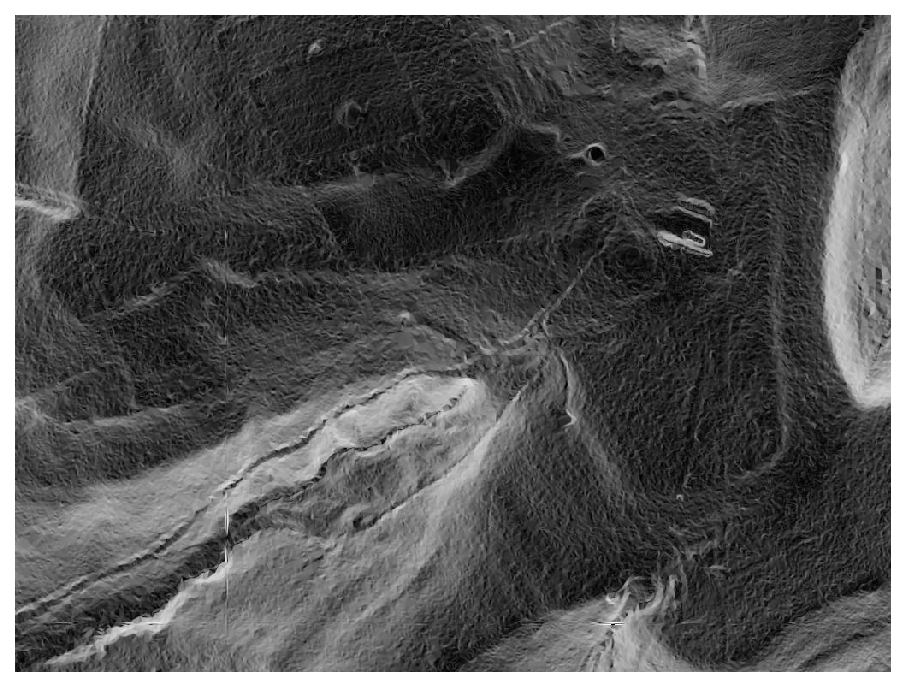

In [6]:
# display image with masks and bounding boxes
from os import listdir
import os
import skimage
import random
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
import cv2

print(cfg_name)
print(model_epoch)

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='/home/student/charcoal_hearth_hill/model/', config=cfg)
# load model weights

model_path = '/home/student/charcoal_hearth_hill/model/'+construction_type+'_'+cfg_name+'/mask_rcnn_'+construction_type+'_cfg_'+model_epoch+'.h5'
    
model.load_weights(model_path, by_name=True)

image_for_prediction_folder = '/home/student/charcoal_hearth_hill/images/jpgs/'

image_prediction_folder = '/home/student/data_5000_project/data/images/construction_types/processed/'+construction_type+'/predictions/'+cfg_name+"/unknown/"
if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)

# Load a random image from the images folder
file_names = next(os.walk(image_for_prediction_folder))[2]
#print(file_names)
class_names = [construction_type,construction_type]
for cn in range(1,2):
    
    #image = skimage.io.imread(os.path.join(image_for_prediction_folder, random.choice(file_names)),False)
    # load the image as RGB
    # https://github.com/matterport/Mask_RCNN/issues/1435
    image = cv2.imread(os.path.join(image_for_prediction_folder, random.choice(file_names)))
    # Run detection
    results = model.detect([image], verbose=1)
    # Visualize results
    r = results[0]
    image2= display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


In [4]:
# Run only once
cause.errir
# For 100 randomly selected images from all images 
# image_for_prediction_folder = '/home/student/charcoal_hearth_hill/images/jpgs/'
# For 100 randomly selected images from just training
import os
import random
image_for_prediction_folder = '/home/student/charcoal_hearth_hill/images_training/'

file_names = next(os.walk(image_for_prediction_folder))[2]
#print(file_names)
test_file_names=[]
for cn in range(0,100):
    test_file_names.append(random.choice(file_names))

print(test_file_names)

import pickle
#with open('rcnn_100_random_images_charcoal_hearth_hill.pkl', 'wb') as f:
with open('rcnn_100_random_images_training_charcoal_hearth_hill.pkl', 'wb') as f:
    pickle.dump(test_file_names, f)
    

#with open('rcnn_100_random_images_charcoal_hearth_hill.pkl', 'rb') as f:
with open('rcnn_100_random_images_training_charcoal_hearth_hill.pkl', 'rb') as f:
    test_file_names = pickle.load(f)


['217pas2016.jpg', '073pas2609.jpg', '156pas0908.jpg', '058pan1508.jpg', '046pas0700.jpg', '063pan0604.jpg', '073pas1908.jpg', '046pas0906.jpg', '047pan0805.jpg', '055pan0909.jpg', '041pas1305.jpg', '042pas3317.jpg', '039pan1408.jpg', '051pas1914.jpg', '072pan0903.jpg', '076pas0104.jpg', '041pas1308.jpg', '039pan1809.jpg', '217pas1409.jpg', '058pan1517.jpg', '045pan0507.jpg', '052pas1008.jpg', '043pas0801.jpg', '261pas1104.jpg', '043pas0905.jpg', '073pas1904.jpg', '052pas0905.jpg', '063pan0403.jpg', '058pan1611.jpg', '043pas1207.jpg', '043pas1106.jpg', '073pas2407.jpg', '052pas0707.jpg', '217pas2018.jpg', '115pan0504.jpg', '115pan0506.jpg', '041pas1109.jpg', '042pas0105.jpg', '156pas0801.jpg', '217pan0303.jpg', '073pas4416.jpg', '043pas0807.jpg', '058pan1406.jpg', '046pas0906.jpg', '217pan0200.jpg', '043pas0806.jpg', '046pas0802.jpg', '073pas1904.jpg', '041pas0503.jpg', '063pan1803.jpg', '043pas0506.jpg', '217pas1812.jpg', '063pan0306.jpg', '063pan1804.jpg', '217pan0910.jpg', '073pas19

In [7]:
# Write Annot
def write_annot(obj_type, obj_annots_dir, obj_f_num, org_f_name, org_f_path,org_f_width,org_f_height,org_f_depth, refPts, scores):
    # With credit to: 
    # https://www.geeksforgeeks.org/reading-writing-text-files-python/
    annot_file_path = obj_annots_dir+obj_f_num+'.xml'
    annot_file = open(annot_file_path,"w") 

    annot_file.write("<annotation>\n") 
    annot_file.write("	<folder>"+obj_type+"</folder>\n") 
    annot_file.write("	<filename>"+org_f_name+"</filename>\n") 
    annot_file.write("	<path>"+org_f_path+"</path>\n") 
    annot_file.write("	<source>\n") 
    annot_file.write("		<database>Muhlenberg_charcoal_hearths</database>\n") 
    annot_file.write("	</source>\n") 
    annot_file.write("	<size>\n") 
    annot_file.write("		<width>"+str(org_f_width)+"</width>\n") 
    annot_file.write("		<height>"+str(org_f_height)+"</height>\n") 
    annot_file.write("		<depth>"+str(org_f_depth)+"</depth>\n") 
    annot_file.write("	</size>\n")
    annot_file.write("	<!-- <object_present>0 = the object is not present in the image. 1 = it is -->\n")
    annot_file.write("	<object_present>0</object_present>\n")    
    for ocn in range(0,len(refPts)):
        refPt = refPts[ocn]
        refPtMin = refPt[0]
        refPtMax = refPt[1]
        annot_file.write("	<object>\n") 
        annot_file.write("		<name>"+obj_type+"</name>\n") 
        annot_file.write("		<number>"+str(ocn)+"</number>\n") 
        annot_file.write("		<score>"+str(scores[ocn])+"</score>\n")
        annot_file.write("		<correct>0</correct>\n")
        annot_file.write("		<bndbox>\n") 
        annot_file.write("			<xmin>"+str(refPtMin[0])+"</xmin>\n") 
        annot_file.write("			<ymin>"+str(refPtMin[1])+"</ymin>\n") 
        annot_file.write("			<xmax>"+str(refPtMax[0])+"</xmax>\n") 
        annot_file.write("			<ymax>"+str(refPtMax[1])+"</ymax>\n") 
        annot_file.write("		</bndbox>\n") 
        annot_file.write("	</object>\n") 
    annot_file.write("</annotation>\n") 
    annot_file.close() 

## Predict 100 images listed in the .pkl file

In [ ]:
print("cfg_name:",cfg_name)
import pickle
import os
from os import listdir
import skimage
import random
import cv2
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# with open('rcnn_100_random_images_charcoal_hearth_hill.pkl', 'rb') as f:
with open('rcnn_100_random_images_training_charcoal_hearth_hill.pkl', 'rb') as f:
    test_file_names = pickle.load(f)

#set this above
#cfg_name = 'cfg20200307T0901'    
# display image with masks and bounding boxes


object_type = "charcoal_hearth_hill"

image_prediction_folder = os.path.join('/home/student/', (object_type + "/"), 'predictions/', (cfg_name + "/"))
print(image_prediction_folder)
if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)

# The "unknown" folder is for predictions that have not been scored by a human.
# image_prediction_folder = os.path.join(image_prediction_folder,"unknown/")
image_prediction_folder = os.path.join(image_prediction_folder,"unknown_training/")
if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='/home/student/' + object_type + '/model/', config=cfg)
# load model weights

model_path = '/home/student/' + object_type + '/model/' + object_type + '_'+cfg_name+'/mask_rcnn_'+construction_type+'_cfg_'+model_epoch+'.h5'
# image_for_prediction_folder = '/home/student/charcoal_hearth_hill/images/jpgs/' 
image_for_prediction_folder = '/home/student/charcoal_hearth_hill/images_training/'
model.load_weights(model_path, by_name=True)


#Store the results in XML    
class_names = [construction_type,construction_type,]
for cn in range(0,100):
    image = cv2.imread(os.path.join(image_for_prediction_folder, test_file_names[cn]))
    # Run detection
    results = model.detect([image], verbose=1)
    # Visualize results
    r = results[0]
    image2= display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
    obj_f_num = test_file_names[cn]
    obj_f_num = obj_f_num[:-4]
    refPts = []
    for rcn in range(0,len(r['rois'])):
        refPt = []
        refPtM = []
        refPtM.append(r['rois'][rcn][1])
        refPtM.append(r['rois'][rcn][0])
        refPt.append(refPtM)
        refPtM = []
        refPtM.append(r['rois'][rcn][3])
        refPtM.append(r['rois'][rcn][2])
        refPt.append(refPtM)
        refPts.append(refPt)
        #print(refPts)
    print(cn, obj_f_num)     
    write_annot(class_names[0], image_prediction_folder, obj_f_num, test_file_names[cn], image_for_prediction_folder,image.shape[1],image.shape[0],image.shape[2], refPts,r['scores'])


# Predict all of the images

In [ ]:
# Predict it for all the images
# Run Predict Config and Write Annot before running this cell.
print("cfg_name:",cfg_name)

#For all of the jpegs, run prediction

#images_dir
# Run on all images - produce results for analysis.
images_dir = '/home/student/charcoal_hearth_hill/images/jpgs/'

# Use this to rerun for all the training images (improve the training data with a second pass)
# images_dir = '/home/student/charcoal_hearth_hill/images_training_selected/'



#set this above
#cfg_name = 'cfg20200307T0901'    
import os
from os import listdir
import skimage
import cv2
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='/home/student/charcoal_hearth_hill/model/', config=cfg)
# load model weights

model_path = '/home/student/charcoal_hearth_hill/model/'+construction_type+'_'+cfg_name+'/mask_rcnn_'+construction_type+'_cfg_'+model_epoch+'.h5'
model.load_weights(model_path, by_name=True)

image_prediction_folder = '/home/student/'+construction_type+'/predictions/'+cfg_name

# output for retrain run
#image_prediction_folder = '/home/student/' + construction_type + '/retrain/'+cfg_name

#image_for_prediction_folder = '/home/student/charcoal_hearth_hill/images/jpgs/'  
image_for_prediction_folder = images_dir

if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)
image_prediction_folder = image_prediction_folder+'/unknown/'
if not os.path.exists(image_prediction_folder):
    os.mkdir(image_prediction_folder)
    
    
#Store the results in XML    
class_names = [construction_type,construction_type,]


# find all images
for filename in listdir(images_dir):
    # extract image id
    image_id = filename[:-4]
    img_path = images_dir + filename
    #ann_path = annotations_dir + image_id + '.xml'
    #print(image_id,img_path,ann_path)
    print(image_id,img_path)
    
    image = cv2.imread(img_path)
    #image = skimage.io.imread(os.path.join(image_for_prediction_folder, test_file_names[cn]))
    #print("shape:", image.shape)
    # Run detection
    results = model.detect([image], verbose=1)
    # Visualize results
    r = results[0]
    #print(r['rois'], class_names, r['scores'])
    #print(r['rois'][1],r['rois'][1][0],r['rois'][1][1],r['rois'][1][2],r['rois'][1][3])
    #image2= display_instances(image, r['rois'], r['masks'], r['class_ids'], 
    #class_names, r['scores'])
    obj_f_num = image_id
    refPts = []
    for rcn in range(0,len(r['rois'])):
        refPt = []
        refPtM = []
        refPtM.append(r['rois'][rcn][1])
        refPtM.append(r['rois'][rcn][0])
        refPt.append(refPtM)
        refPtM = []
        refPtM.append(r['rois'][rcn][3])
        refPtM.append(r['rois'][rcn][2])
        refPt.append(refPtM)
        refPts.append(refPt)
        #print(refPts)
    write_annot(class_names[0], image_prediction_folder, obj_f_num, filename, image_for_prediction_folder,image.shape[1],image.shape[0],image.shape[2], refPts,r['scores'])
print("The results are in: "+image_prediction_folder)

In [ ]:
/home/student/charcoal_hearth_hill/predictions/cfg20200826T2315/unknown/